In [1]:
#  1. Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)

import warnings
warnings.filterwarnings("ignore")


In [2]:
#  2. Load + Clean Data 
resumes = pd.read_csv("RESUME_SCREENING_DATASET.csv")
resumes.fillna("", inplace=True)

# Combine relevant features
resumes["combined_text"] = (
    resumes["skills"] + " " +
    resumes["education"] + " " +
    resumes["last_job_title"] + " " +
    resumes["job_history"].astype(str)
)

# Final dataframe
resumes = resumes[["combined_text", "is_relevant"]]
resumes.head()


,combined_text,is_relevant
0,"Python, Java, JavaScript, C++, SQL, NoSQL, AWS...",0
1,"Python, Java, JavaScript, SQL, NoSQL, Azure, K...",0
2,"Python, Java, JavaScript, C++, SQL, NoSQL, AWS...",1
3,"Python, Java, JavaScript, C++, SQL, NoSQL, AWS...",0
4,"Python, C++, SQL, NoSQL, AWS, Azure, Docker, K...",0


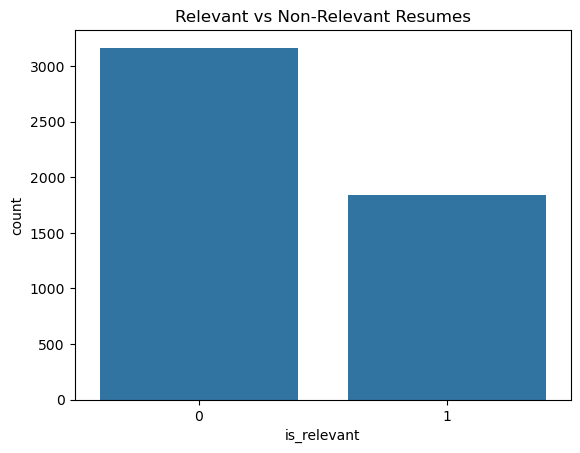

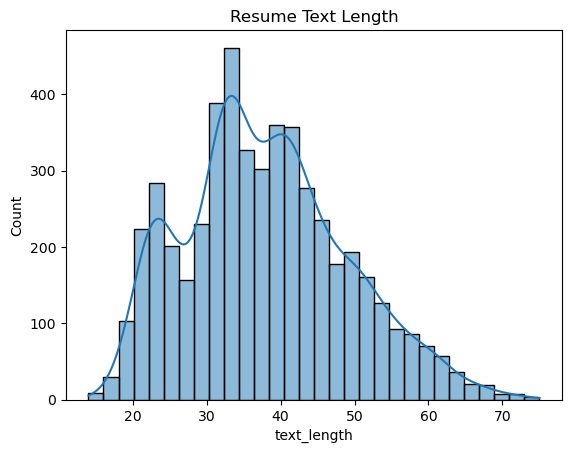

In [3]:
#  3. EDA 

# Class balance
sns.countplot(x="is_relevant", data=resumes)
plt.title("Relevant vs Non-Relevant Resumes")
plt.show()

# Resume length
resumes["text_length"] = resumes["combined_text"].apply(lambda x: len(x.split()))
sns.histplot(resumes["text_length"], bins=30, kde=True)
plt.title("Resume Text Length")
plt.show()


In [4]:
#  4. TF-IDF & Train/Test Split 

tfidf = TfidfVectorizer(stop_words="english", max_features=3000)
X = tfidf.fit_transform(resumes["combined_text"]).toarray()
y = resumes["is_relevant"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# 5. Evaluation Function ----------------- #
def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    print(f"\n Evaluating: {name}")
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\n Training Set Metrics:")
    print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.2f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.2f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred):.2f}")
    print(f"F1 Score:  {f1_score(y_train, y_train_pred):.2f}")

    print("\n Test Set Metrics:")
    print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred):.2f}")
    print(f"F1 Score:  {f1_score(y_test, y_test_pred):.2f}")

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()



 Evaluating: Logistic Regression

 Training Set Metrics:
Accuracy:  0.84
Precision: 0.75
Recall:    0.84
F1 Score:  0.79

 Test Set Metrics:
Accuracy:  0.77
Precision: 0.66
Recall:    0.72
F1 Score:  0.68


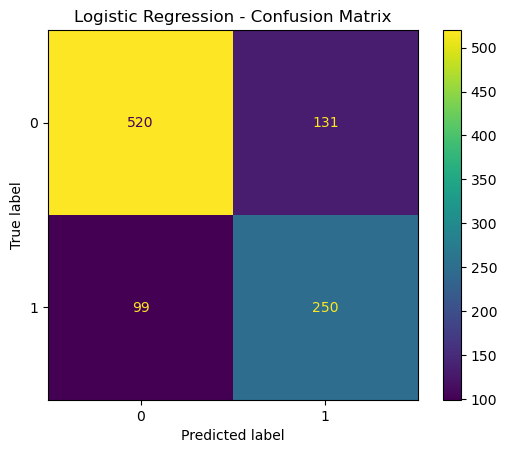

In [6]:
# 6. Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)

evaluate_model(lr, X_train, X_test, y_train, y_test, name="Logistic Regression")



 Evaluating: Tuned Random Forest

 Training Set Metrics:
Accuracy:  0.80
Precision: 0.72
Recall:    0.77
F1 Score:  0.74

 Test Set Metrics:
Accuracy:  0.77
Precision: 0.66
Recall:    0.68
F1 Score:  0.67


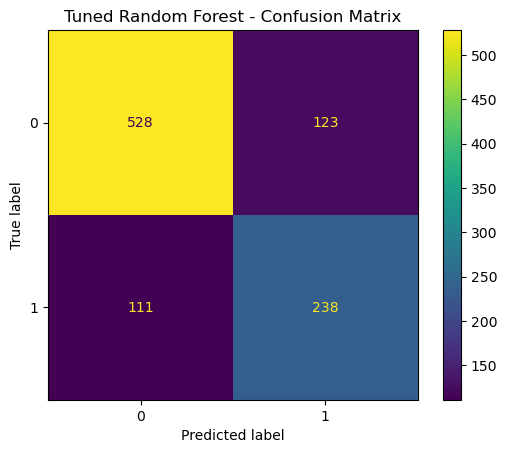

In [10]:
#  7. Random Forest 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,              
    min_samples_split=10,     
    min_samples_leaf=4,       
    max_features='sqrt',       
    random_state=42
)
rf.fit(X_train, y_train)

evaluate_model(rf, X_train, X_test, y_train, y_test, name="Tuned Random Forest")


 Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

 Evaluating: Tuned Logistic Regression

 Training Set Metrics:
Accuracy:  0.84
Precision: 0.75
Recall:    0.84
F1 Score:  0.79

 Test Set Metrics:
Accuracy:  0.77
Precision: 0.66
Recall:    0.71
F1 Score:  0.68


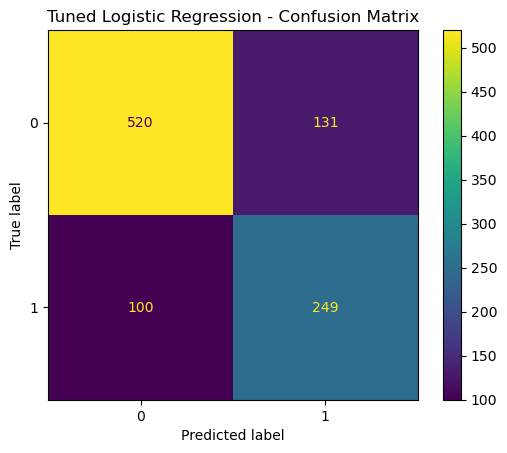

In [14]:
#  8. Grid Search on Logistic Regression 
params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear"]
}

grid = GridSearchCV(LogisticRegression(), params, cv=5, scoring="f1")
grid.fit(X_train, y_train)

print(" Best Params:", grid.best_params_)

best_lr = grid.best_estimator_
evaluate_model(best_lr, X_train, X_test, y_train, y_test, name="Tuned Logistic Regression")


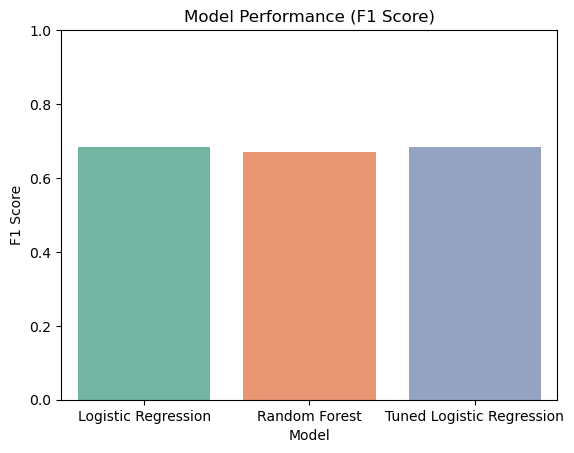

In [16]:
#  9. Compare All Models 
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Tuned Logistic Regression"],
    "F1 Score": [
        f1_score(y_test, lr.predict(X_test)),
        f1_score(y_test, rf.predict(X_test)),
        f1_score(y_test, best_lr.predict(X_test))
    ]
})

sns.barplot(data=results, x="Model", y="F1 Score", palette="Set2")
plt.title("Model Performance (F1 Score)")
plt.ylim(0, 1)
plt.show()
